# SVM Intuition: Dot Products, Distances, and Simple Linear SVMs

This notebook builds geometric intuition for **dot products** and **distances**, then connects them to
a **linear SVM** on a toy 2D dataset. It finishes with a small experiment on two digits
(MNIST if available, otherwise the scikit-learn 8×8 digits as a fallback).

**Conventions (ISLP-style):** decision function $f(x) = w^\top x + b$; margin $\frac{|w^\top x + b|}{\|w\|}$;
hinge loss $\max(0, 1 - y\,f(x))$ with labels $y\in\{-1,+1\}$.


## 1) Dot product intuition

Think of $u\cdot v$ as **how much of $u$ lies along $v$**, i.e., the length of the **projection** of $u$
onto $v$ times $\|v\|$. If $u\cdot v>0$, they broadly point in the same direction; if $<0$, in opposite directions.

Run the next cell and examine the vectors, the projection $\mathrm{proj}_v(u)$, and the residual $u-\mathrm{proj}_v(u)$.


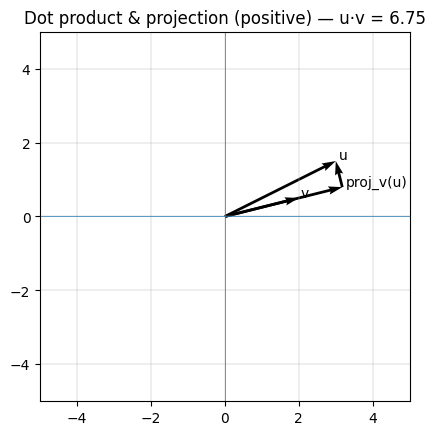

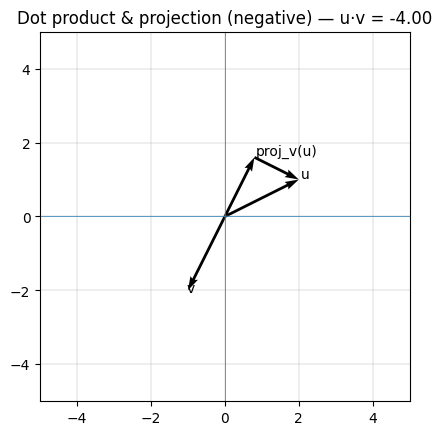

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_vectors_and_projection(u, v, title_suffix=""):
    plt.figure()
    plt.quiver(0, 0, u[0], u[1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1)
    t = (u @ v) / (v @ v)
    proj = t * v
    r = u - proj
    plt.quiver(0, 0, proj[0], proj[1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(proj[0], proj[1], r[0], r[1], angles='xy', scale_units='xy', scale=1)
    plt.text(u[0]*1.03, u[1]*1.03, "u")
    plt.text(v[0]*1.03, v[1]*1.03, "v")
    plt.text(proj[0]*1.03, proj[1]*1.03, "proj_v(u)")
    plt.axhline(0, linewidth=0.5); plt.axvline(0, linewidth=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(-5, 5); plt.ylim(-5, 5)
    plt.grid(True, linewidth=0.3)
    dp = float(u @ v)
    plt.title(f"Dot product & projection{title_suffix} — u·v = {dp:.2f}")

u1 = np.array([3.0, 1.5])
v1 = np.array([2.0, 0.5])
plot_vectors_and_projection(u1, v1, " (positive)")

u2 = np.array([2.0, 1.0])
v2 = np.array([-1.0, -2.0])
plot_vectors_and_projection(u2, v2, " (negative)")

### EXERCISE A — Try your own vectors
Pick new vectors $u$ and $v$ and re-run the plot. Compute by hand:
- $u\cdot v$

= -11

- $\|u\|$, $\|v\|$

sqrt(5), 5

- the projection coefficient $t=\dfrac{u\cdot v}{\|v\|^2}$

(1.32, 1.76)

u·v = -11.0
||u|| = 2.23606797749979 ||v|| = 5.0
t = -0.44


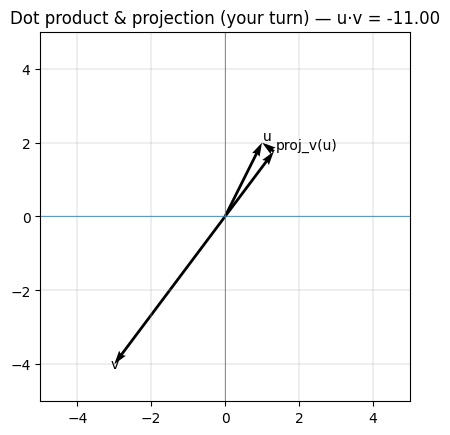

In [13]:
# TODO: set your own vectors, then run
u = np.array([1, 2])
v = np.array([-3, -4])
plot_vectors_and_projection(u, v, " (your turn)")
print("u·v =", float(u@v))
print("||u|| =", float(np.linalg.norm(u)), "||v|| =", float(np.linalg.norm(v)))
print("t =", float((u@v)/(v@v)))

## 2) Visualizing distances

For two points $a,b\in\mathbb{R}^2$, the Euclidean distance is
$$
\|a-b\| = \sqrt{(a_1-b_1)^2 + (a_2-b_2)^2} = \sqrt{\|a\|^2 + \|b\|^2 - 2a\cdot b}.
$$
The plot shows the segment between two points and annotates its length.


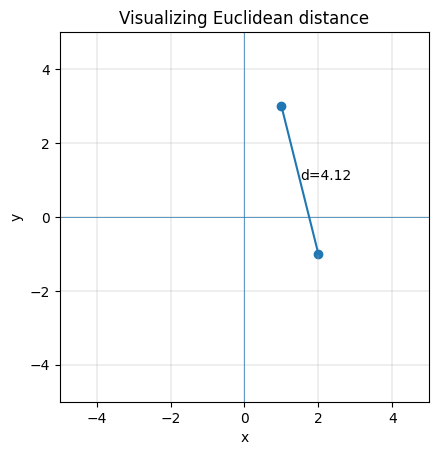

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_points_and_distance(a, b, title="Distance between two points"):
    plt.figure()
    plt.scatter([a[0], b[0]], [a[1], b[1]])
    plt.plot([a[0], b[0]], [a[1], b[1]])
    d = np.linalg.norm(a - b)
    mid = (a + b) / 2
    plt.text(mid[0], mid[1], f"d={d:.2f}")
    plt.axhline(0, linewidth=0.5); plt.axvline(0, linewidth=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(-5, 5); plt.ylim(-5, 5)
    plt.grid(True, linewidth=0.3)
    plt.xlabel("x"); plt.ylabel("y")
    plt.title(title)

a = np.array([2.0, -1.0])
b = np.array([1.0, 3.0])
plot_points_and_distance(a, b, "Visualizing Euclidean distance")

### EXERCISE B — Pairwise distances and dot products
For the set $P=\{(1,0),(0,2),(-1,1)\}$, compute a $3\times3$ table of dot products $(p_i\cdot p_j)$
and another of squared distances $\|p_i-p_j\|^2$. (You can code it below or do by hand.)

In [15]:
# TODO: fill in P and compute pairwise dot products and squared distances
import numpy as np

P = np.array([[1.0, 0.0],
              [0.0, 2.0],
              [-1.0, 1.0]])

def pairwise_dot(X):
    return X @ X.T

def pairwise_sqdist(X):
    G = pairwise_dot(X)
    diag = np.diag(G)
    return diag[:,None] + diag[None,:] - 2*G

dots = pairwise_dot(P)
d2 = pairwise_sqdist(P)
print("Pairwise dot products:\n", dots)
print("\nPairwise squared distances:\n", d2)

Pairwise dot products:
 [[ 1.  0. -1.]
 [ 0.  4.  2.]
 [-1.  2.  2.]]

Pairwise squared distances:
 [[0. 5. 5.]
 [5. 0. 2.]
 [5. 2. 0.]]


## 3) Linear SVM on a simple 2D dataset

We generate two Gaussian blobs (labels $\pm1$), fit a linear SVM, and plot the **decision boundary**
$w^\top x + b=0$ and the **margins** $w^\top x + b=\pm 1$ (in original coordinates).
The points marked with an 'x' are the **support vectors**.


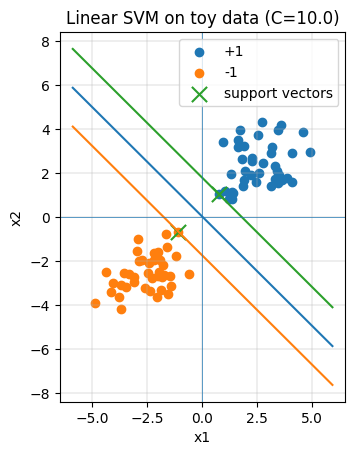

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

np.random.seed(7)

def make_toy_blobs(n_per_class=40, separation=2.5):
    cov = np.array([[1.0, 0.4],[0.4, 1.0]])
    mean_pos = np.array([ separation,  separation])
    mean_neg = np.array([-separation, -separation])
    X_pos = np.random.multivariate_normal(mean_pos, cov, size=n_per_class)
    X_neg = np.random.multivariate_normal(mean_neg, cov, size=n_per_class)
    X = np.vstack([X_pos, X_neg])
    y = np.hstack([np.ones(n_per_class), -np.ones(n_per_class)])
    return X, y

def plot_linear_svm_2d(X, y, C=10.0):
    clf = Pipeline([("scaler", StandardScaler()), ("svm", SVC(kernel="linear", C=C))])
    clf.fit(X, y)
    svc = clf.named_steps["svm"]; scaler = clf.named_steps["scaler"]
    w_z = svc.coef_.ravel(); b_z = float(svc.intercept_[0])
    scale = scaler.scale_; mean = scaler.mean_
    w_x = w_z / scale; b_x = b_z - np.dot(w_z, mean/scale)

    plt.figure()
    plt.scatter(X[y==1,0], X[y==1,1], label="+1")
    plt.scatter(X[y==-1,0], X[y==-1,1], label="-1")
    if abs(w_x[1]) > 1e-12:
        xs = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200)
        db  = -(w_x[0]/w_x[1])*xs - b_x/w_x[1]
        m1  = -(w_x[0]/w_x[1])*xs - (b_x+1)/w_x[1]
        m_1 = -(w_x[0]/w_x[1])*xs - (b_x-1)/w_x[1]
        plt.plot(xs, db); plt.plot(xs, m1); plt.plot(xs, m_1)
    SV_z = svc.support_vectors_; SV_x = SV_z * scale + mean
    plt.scatter(SV_x[:,0], SV_x[:,1], s=120, marker='x', label="support vectors")
    plt.legend(); plt.axhline(0, linewidth=0.5); plt.axvline(0, linewidth=0.5)
    plt.gca().set_aspect('equal', adjustable='box'); plt.grid(True, linewidth=0.3)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.title(f"Linear SVM on toy data (C={C})")

X, y = make_toy_blobs()
plot_linear_svm_2d(X, y, C=10.0)

### EXERCISE C — Change the regularization and measure hinge loss
1. Re-run the previous cell with different values of $C$ (e.g., $0.1, 1, 10$). Describe how the margin/support vectors change.
2. Compute the hinge losses $\max(0, 1 - y_i (w^\top x_i + b))$ for all points and report the average.


In [37]:
# TODO: compute hinge losses for the current fitted model.
# Hint: after fitting the Pipeline 'clf', you can recover w_x and b_x as in the code above,
# then compute margins m_i = y_i * (X_i dot w_x + b_x).
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

np.random.seed(7)

def make_toy_blobs(n_per_class=40, separation=2.5):
    cov = np.array([[1.0, 0.4],[0.4, 1.0]])
    mean_pos = np.array([ separation,  separation])
    mean_neg = np.array([-separation, -separation])
    X_pos = np.random.multivariate_normal(mean_pos, cov, size=n_per_class)
    X_neg = np.random.multivariate_normal(mean_neg, cov, size=n_per_class)
    X = np.vstack([X_pos, X_neg])
    y = np.hstack([np.ones(n_per_class), -np.ones(n_per_class)])
    return X, y

def plot_linear_svm_2d(X, y, C=1.0):
    clf = Pipeline([("scaler", StandardScaler()), ("svm", SVC(kernel="linear", C=C))])
    clf.fit(X, y)
    svc = clf.named_steps["svm"]; scaler = clf.named_steps["scaler"]
    w_z = svc.coef_.ravel(); b_z = float(svc.intercept_[0])
    scale = scaler.scale_; mean = scaler.mean_
    w_x = w_z / scale; b_x = b_z - np.dot(w_z, mean/scale)
    print(w_x);
    plt.figure()
    print(w_x);
    plt.scatter(X[y==1,0], X[y==1,1], label="+1")
    print(w_x);
    plt.scatter(X[y==-1,0], X[y==-1,1], label="-1")
    print(w_x);
    if abs(w_x[1]) > 1e-12:
      print(w_x);
      xs = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200)
      print(w_x);
      db  = -(w_x[0]/w_x[1])*xs - b_x/w_x[1]
      print(w_x);
      m1  = -(w_x[0]/w_x[1])*xs - (b_x+1)/w_x[1]
      print(w_x);
      m_1 = -(w_x[0]/w_x[1])*xs - (b_x-1)/w_x[1]
      print(w_x);
      plt.plot(xs, db); plt.plot(xs, m1); plt.plot(xs, m_1)
      print(w_x);
    SV_z = svc.support_vectors_; SV_x = SV_z * scale + mean
    print(w_x);
    plt.scatter(SV_x[:,0], SV_x[:,1], s=120, marker='x', label="support vectors")
    print(w_x);
    plt.legend(); plt.axhline(0, linewidth=0.5); plt.axvline(0, linewidth=0.5)
    print(w_x);
    plt.gca().set_aspect('equal', adjustable='box'); plt.grid(True, linewidth=0.3)
    print(w_x);
    plt.xlabel("x1"); plt.ylabel("x2")
    print(w_x);
    plt.title(f"Linear SVM on toy data (C={C})")
    print(w_x);

    X, y = make_toy_blobs()
    print(w_x);
    plot_linear_svm_2d(X, y, C=1.0)
    print(w_x);
# Example skeleton:
#m = y * (X @ w_x + b_x)
#hinge = np.maximum(0.0, 1.0 - m)
#print("Average hinge loss:", hinge.mean())

pass

## 4) Two-digit classification: Linear SVM vs LDA

We try to use **MNIST** (digits 3 vs 8). If MNIST is unavailable in this environment (no internet/cache),
we fall back to scikit-learn's 8×8 digits dataset (also digits 3 vs 8).

Both models are trained on flattened pixel features after scaling to $[0,1]$ and standardized per feature.
We report held-out test accuracy and show confusion matrices.


Dataset used: MNIST
Linear SVM accuracy: 0.9825
LDA accuracy: 0.905


Text(0, 0.5, 'True')

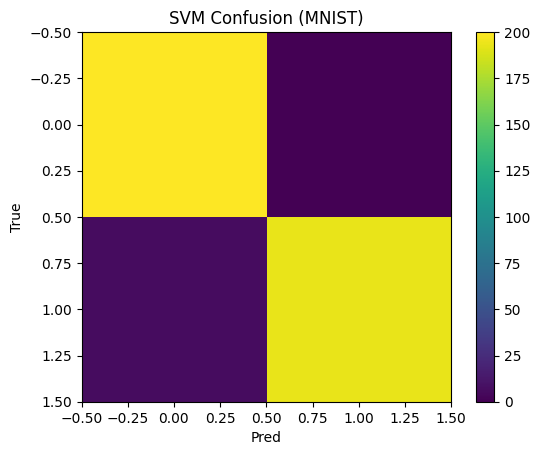

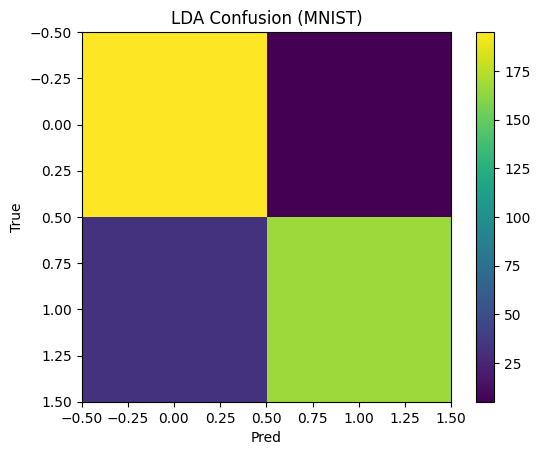

In [39]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets import load_digits as sklearn_load_digits
import matplotlib.pyplot as plt

def try_load_mnist_two_digits(d1=1, d2=7, limit_per_class=150):
    try:
        from tensorflow.keras.datasets import mnist
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
        train_mask = np.isin(y_train, [d1, d2]); test_mask = np.isin(y_test, [d1, d2])
        X_train = X_train[train_mask]; y_train = y_train[train_mask]
        X_test = X_test[test_mask];   y_test  = y_test[test_mask]
        if limit_per_class is not None:
            def limit(X, y, digit, k):
                idx = np.where(y==digit)[0][:k]
                return X[idx], y[idx]
            X1, y1 = limit(X_train, y_train, d1, limit_per_class)
            X2, y2 = limit(X_train, y_train, d2, limit_per_class)
            X_train = np.vstack([X1, X2]); y_train = np.concatenate([y1, y2])
            X1t, y1t = limit(X_test, y_test, d1, max(200, limit_per_class))
            X2t, y2t = limit(X_test, y_test, d2, max(200, limit_per_class))
            X_test = np.vstack([X1t, X2t]); y_test = np.concatenate([y1t, y2t])
        X_train = X_train.reshape(len(X_train), -1) / 255.0
        X_test  = X_test.reshape(len(X_test),  -1) / 255.0
        y_train = np.where(y_train==d1, 0, 1); y_test = np.where(y_test==d1, 0, 1)
        return ("MNIST", (X_train, X_test, y_train, y_test))
    except Exception:
        digits = sklearn_load_digits()
        X = digits.data / 16.0; y = digits.target
        mask = np.isin(y, [d1, d2]); X = X[mask]; y = y[mask]
        y = np.where(y==d1, 0, 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
        return ("sklearn_digits_8x8", (X_train, X_test, y_train, y_test))

def evaluate_linear_svm_vs_lda(X_train, X_test, y_train, y_test):
    svm_pipe = Pipeline([("scaler", StandardScaler(with_mean=True)), ("svm", SVC(kernel="linear", C=1.0))])
    svm_pipe.fit(X_train, y_train)
    yhat_svm = svm_pipe.predict(X_test)
    acc_svm = accuracy_score(y_test, yhat_svm)
    cm_svm = confusion_matrix(y_test, yhat_svm)

    lda_pipe = Pipeline([("scaler", StandardScaler(with_mean=True)), ("lda", LDA())])
    lda_pipe.fit(X_train, y_train)
    yhat_lda = lda_pipe.predict(X_test)
    acc_lda = accuracy_score(y_test, yhat_lda)
    cm_lda = confusion_matrix(y_test, yhat_lda)
    return (acc_svm, cm_svm), (acc_lda, cm_lda)

name, (Xtr, Xte, ytr, yte) = try_load_mnist_two_digits()
(acc_svm, cm_svm), (acc_lda, cm_lda) = evaluate_linear_svm_vs_lda(Xtr, Xte, ytr, yte)
print("Dataset used:", name)
print("Linear SVM accuracy:", acc_svm)
print("LDA accuracy:", acc_lda)

plt.figure(); plt.imshow(cm_svm, interpolation='nearest'); plt.title(f"SVM Confusion ({name})"); plt.colorbar(); plt.xlabel("Pred"); plt.ylabel("True")
plt.figure(); plt.imshow(cm_lda, interpolation='nearest'); plt.title(f"LDA Confusion ({name})"); plt.colorbar(); plt.xlabel("Pred"); plt.ylabel("True")

### EXERCISE D — Explore digits and regularization
- Change the two digits (e.g., 1 vs 7) and re-run.  
- Try different $C$ values for the SVM.  
- (Optional) Compare using/omitting standardization before LDA.


---

### What to notice
- Dot products drive both **projections** and the **score** $w^\top x + b$.
- Distance to a line is just a **scaled score**: $\frac{|w^\top x + b|}{\|w\|}$.
- For the toy data, the **support vectors** are the points that touch the margin lines $\pm 1$.
- On digits, a linear SVM and LDA can perform differently; compare accuracies and confusion matrices.
